In [1]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt

import startinpy

dt = startinpy.DT()

## Separating trees from DSM. 

Two tasks:
1. Mask out trees
2. Fill with ground values




# Current

### Create a canopy DSM

1. Load DSM
2. Load Trees (gpkg, will be raster in final?)
3. Create tree mask by rasterizing trees (same extent as dsm)
4. Create canopy dsm by masking trees (fill with 0 or nan, UMEP wants 0?)
5. export canopy dsm

Create building and topography dsm:
5. Load building mask
6. remove buildings and trees from DSM
7. interpolate using startinpy. 
8. reintroduce buildings to interpolated dsm
9. save


Then run umep with both (just buildings and topography and buildings and trees, with veg function)


In [6]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()
    dsm_crs = src.crs

# Read canopy poly
trees = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/lidR/results/25EZ1_21.gpkg')
trees_crs = trees.crs

# Check and reproject if necessary
if trees_crs != dsm_crs:
    trees = trees.to_crs(dsm_crs)


trees.geometry = trees.buffer(1)

# Rasterize tree polygons (same size as dsm so it works with UMEP)
tree_mask = rasterize(
    ((mapping(geom), 1) for geom in trees.geometry),
    out_shape=dsm.shape,
    transform=dsm_meta['transform'],
    fill=0,
    dtype='uint8'
)

# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, np.nan)

# # Save Canopy DSM
# dsm_meta.update(dtype='float32', nodata=np.nan)
# with rasterio.open('canopy_dsm.tif', 'w', **dsm_meta) as dst:
#     dst.write(canopy_dsm, 1)

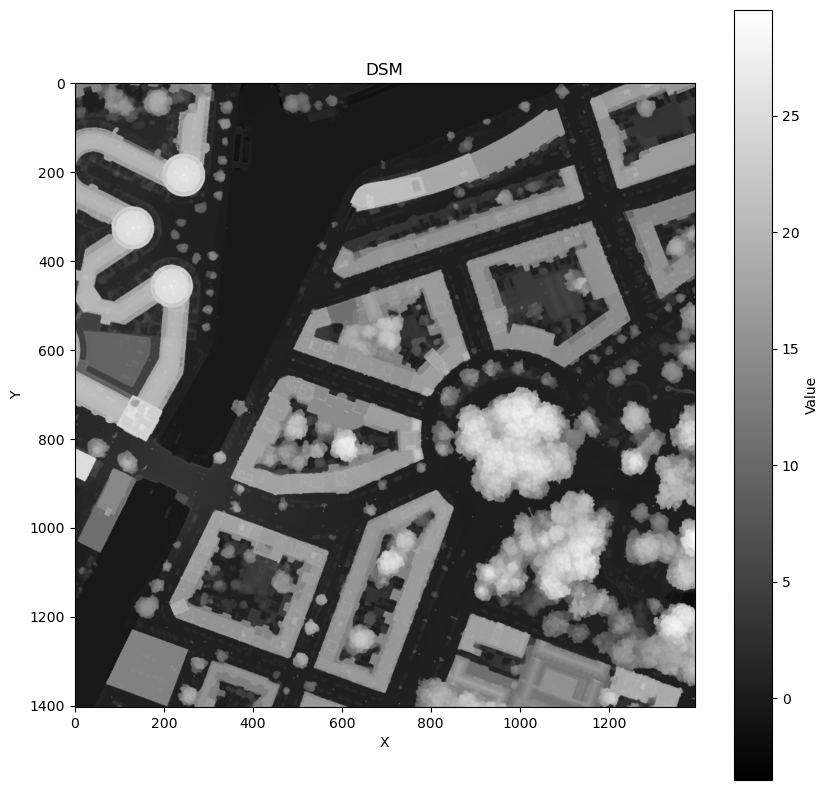

In [7]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(dsm, cmap='gray')
plt.title('DSM')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

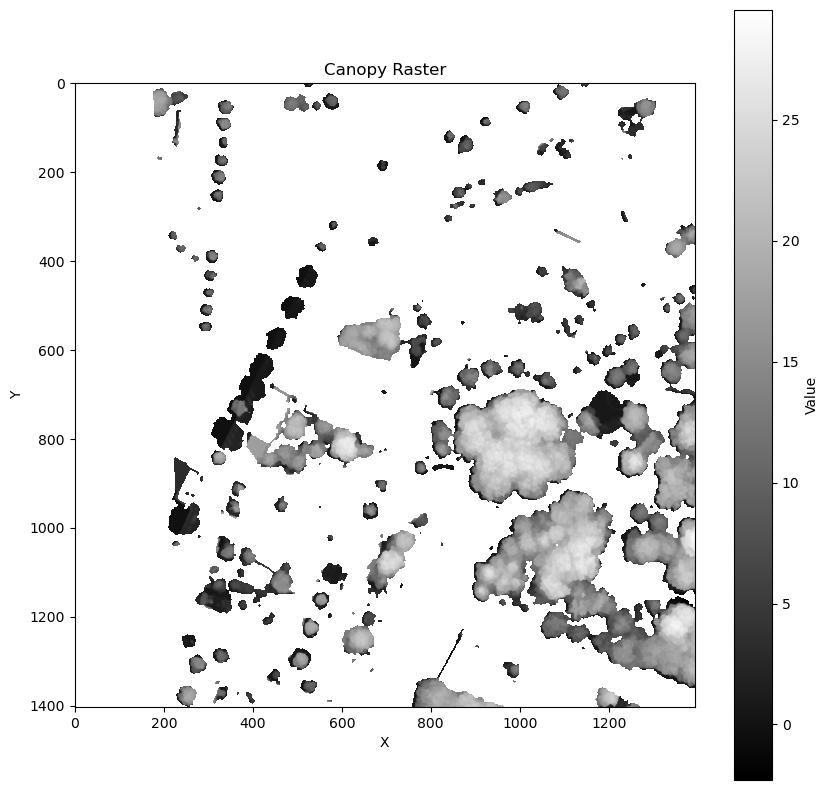

In [8]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(canopy_dsm, cmap='gray')
plt.title('Canopy Raster')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

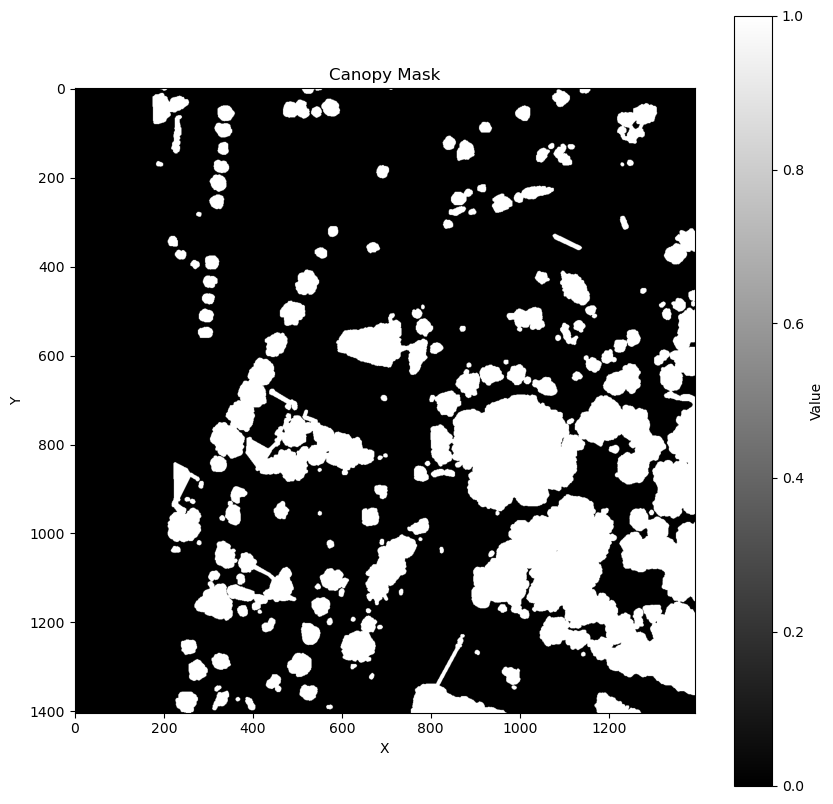

In [9]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(tree_mask, cmap='gray')
plt.title('Canopy Mask')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Two options: Either combine masks first, then mask out (canopy and buildings) or mask separately. 

In [10]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_mask.tif') as src:
    bldg_mask = src.read(1)
    bldg_mask_meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    dtype = src.dtypes[0]

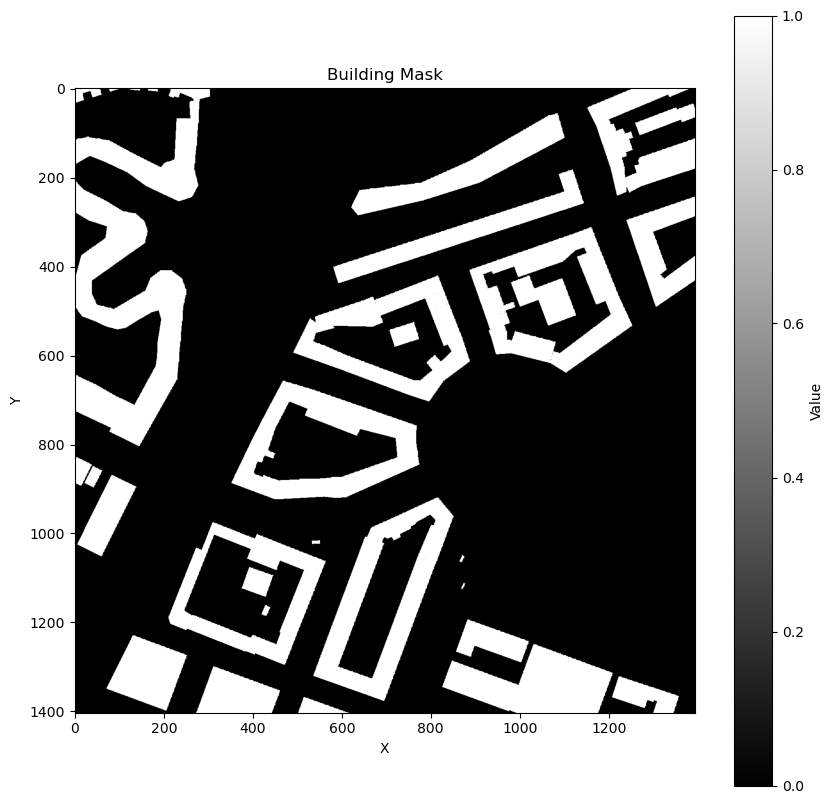

In [11]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(bldg_mask, cmap='gray')
plt.title('Building Mask')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [12]:
bldg_mask.shape

(1403, 1394)

In [13]:
combined_mask = np.logical_or(tree_mask, bldg_mask).astype(np.uint8)
combined_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [36]:
dtm_raw = np.where(combined_mask == 0, dsm, np.nan)

dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/dtm_raw.tif', 'w', **dsm_meta) as dst:
    dst.write(dtm_raw, 1)

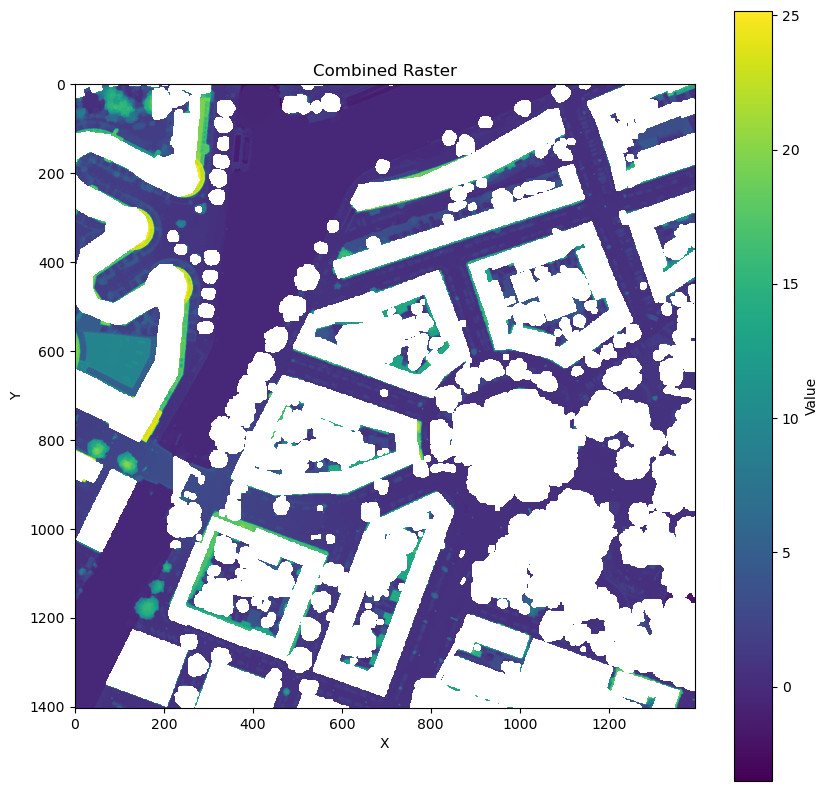

In [39]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(dtm_raw, cmap='viridis')
plt.title('Combined Raster')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Filters

In [76]:
from scipy.ndimage import median_filter
# Function to apply a median filter to a raster dataset
def apply_median_filter(data, nodata_value, size=3):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the median filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = median_filter(data[~mask], size=size)
    
    return filtered_data

from scipy.ndimage import uniform_filter

# Function to apply a mean filter to a raster dataset
def apply_mean_filter(data, nodata_value, size=3):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the mean filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = uniform_filter(data[~mask], size=size)
    
    return filtered_data


from scipy.ndimage import gaussian_filter

# Function to apply a Gaussian filter to a raster dataset
def apply_gaussian_filter(data, nodata_value, sigma=1):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the Gaussian filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = gaussian_filter(data[~mask], sigma=sigma)
    
    return filtered_data

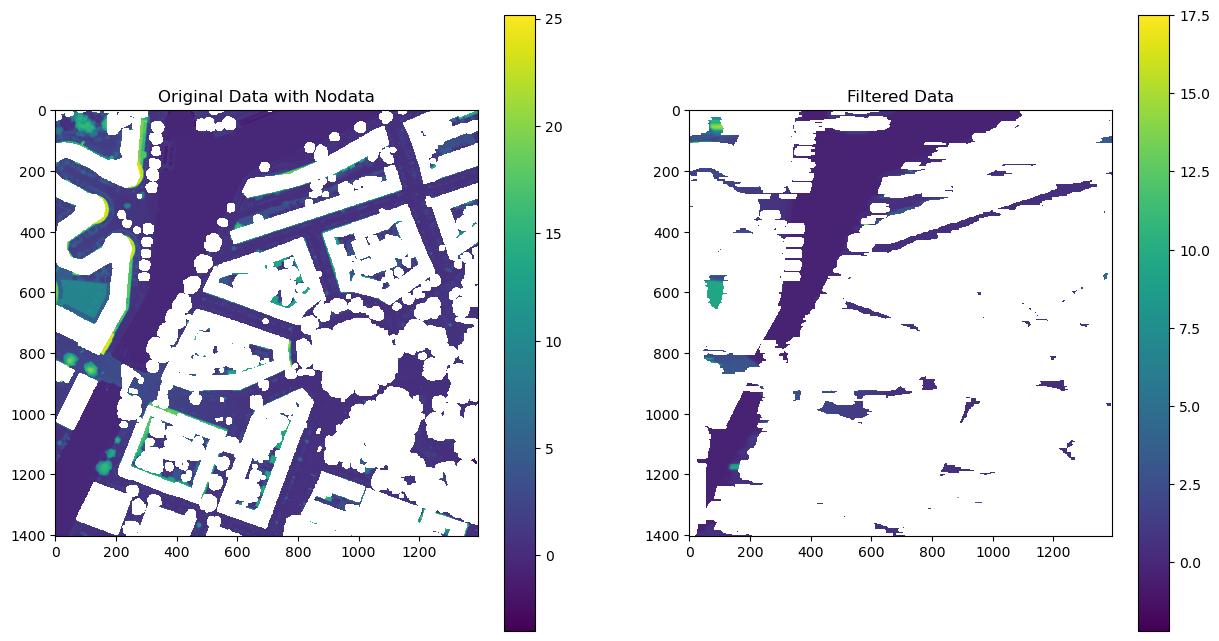

In [94]:
# # Apply median filter
# filtered_data = apply_median_filter(dtm_raw, np.nan, size=10)
# filtered_data = apply_median_filter(filtered_data, np.nan, size=10)

# Apply mean filter
# filtered_data = apply_mean_filter(dtm_raw, np.nan, size=10)


# # Apply Gaussian filter
filtered_data = apply_gaussian_filter(data, np.nan, sigma=3)
# filtered_data = apply_median_filter(filtered_data, np.nan, size=10)


# # Save the filtered raster
# profile.update(dtype=rasterio.float32, nodata=nodata_value)

# with rasterio.open(output_raster, 'w', **profile) as dst:
#     dst.write(filtered_data, 1)

# Plot the original and filtered data for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Original data
cax1 = ax1.imshow(np.where(dtm_raw == np.nan, np.nan, dtm_raw), cmap='viridis')
ax1.set_title('Original Data with Nodata')
fig.colorbar(cax1, ax=ax1, orientation='vertical')

# Filtered data
cax2 = ax2.imshow(np.where(filtered_data == np.nan, np.nan, filtered_data), cmap='viridis')
ax2.set_title('Filtered Data')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

plt.show()

In [95]:
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/dtm_raw_filtered.tif', 'w', **dsm_meta) as dst:
    dst.write(filtered_data, 1)

### Interpolation

In [76]:
import random

In [96]:
with rasterio.open('../data/clean_data/canopydsm/dtm_raw_filtered.tif') as src:
    data = src.read(1)
    bldg_mask_meta = src.meta.copy()
    t = src.transform
    crs = src.crs
    nodata = src.nodata
    dtype = src.dtypes[0]
    # # Replace nodata values with np.nan for easier manipulation
    data = np.where(data == nodata, np.nan, data)
pts = []
coords = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        x = t[2] + (j * t[0]) + (t[0] / 2)
        y = t[5] + (i * t[4]) + (t[4] / 2)
        z = data[i][j]
        if not np.isnan(z):
            pts.append([x, y, z])
            # print('data found')
        else:
            coords.append([x,y])
dt = startinpy.DT()
dt.insert(pts, insertionstrategy="BBox")
dt.interpolate({"method": "TIN"}, coords)

dt.write_ply("../data/clean_data/canopydsm/mydt_test.ply")

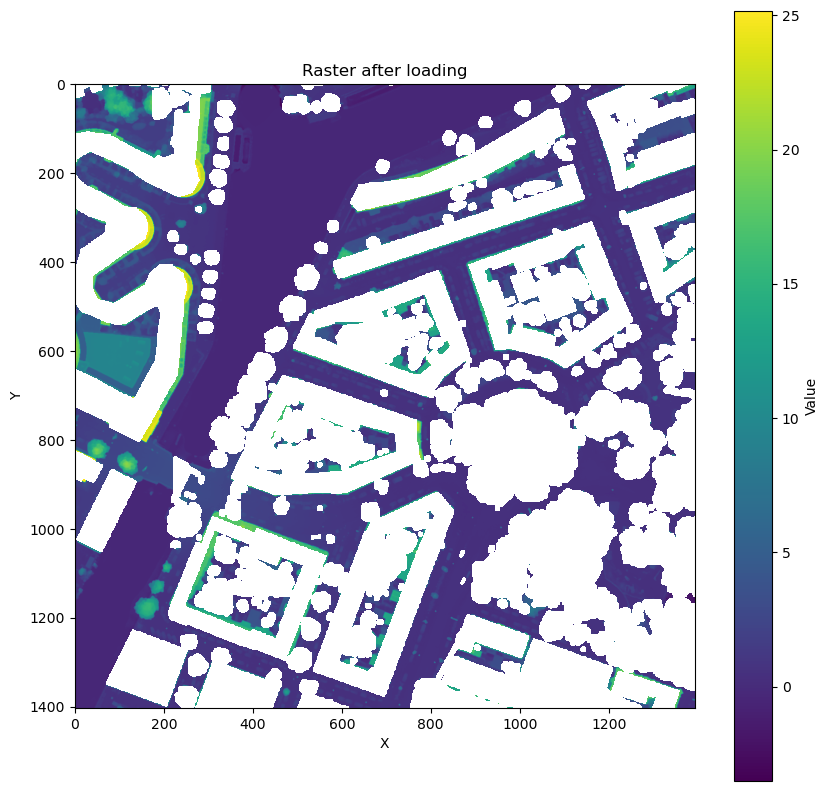

In [44]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='viridis')
plt.title('Raster after loading')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [130]:
nodata

nan

In [108]:
dt.write_ply("../data/clean_data/canopydsm/startinpy_export.ply")

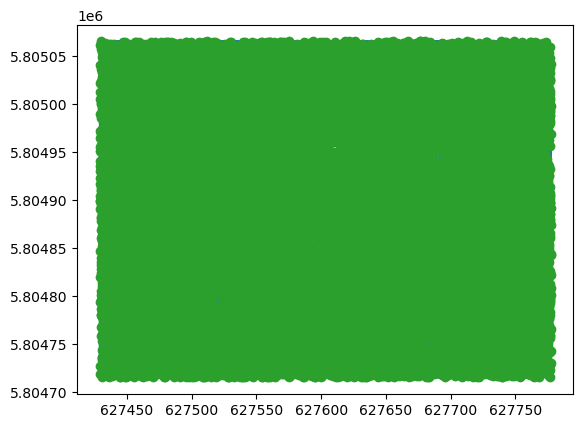

In [116]:
trs = dt.triangles
pts = dt.points
#-- plot
import matplotlib.pyplot as plt
plt.triplot(pts[:,0], pts[:,1], trs)
#-- the vertex "0" shouldn't be plotted, so start at 1
plt.plot(pts[1:,0], pts[1:,1], 'o')
plt.show()

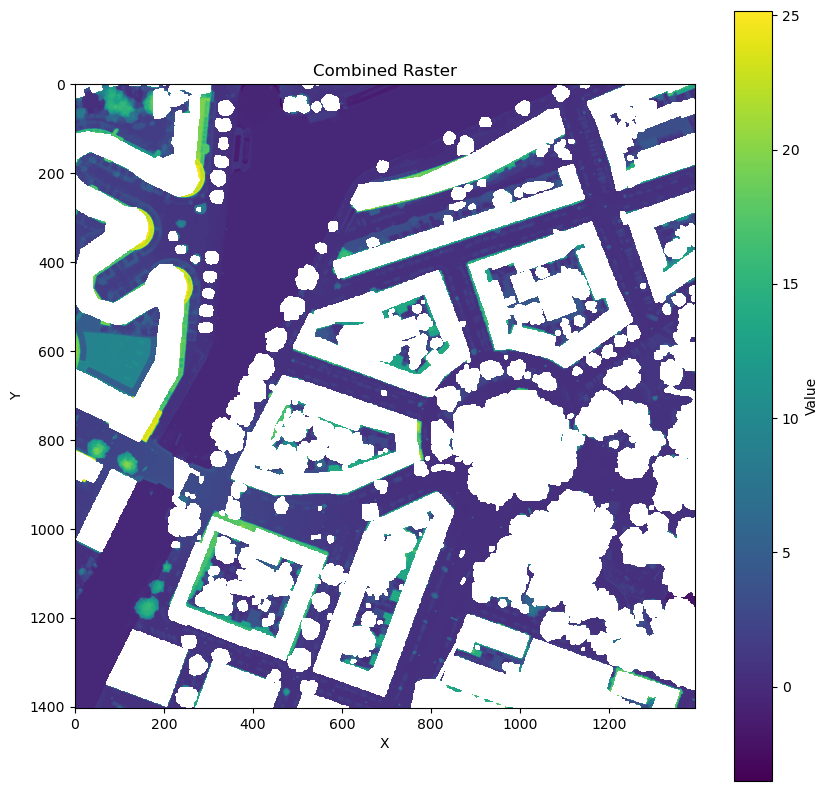

In [125]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(dtm_raw, cmap='viridis')
plt.title('Combined Raster')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [102]:
dt

======== TRIANGULATION ========
# vertices:               19345
# triangles:              38623
# convex hull:               65
---
robust: true
tolerance: 0.001

nan


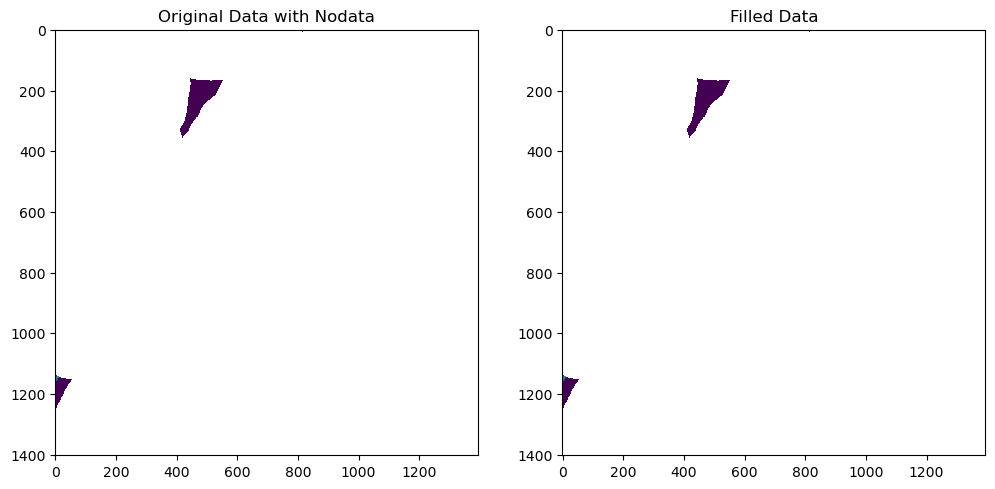

In [14]:
import numpy as np
import rasterio
from rasterio.fill import fillnodata
import matplotlib.pyplot as plt

# Path to your input raster file
input_raster = '../data/clean_data/canopydsm/dtm_raw.tif'
output_raster = '../data/clean_data/canopydsm/dtm.tif'

# Open the raster file
with rasterio.open(input_raster) as src:
    # Read the data
    data = src.read(1)
    profile = src.profile
    nodata_value = src.nodata
    print(nodata_value)

    # # Replace nodata values with np.nan for easier manipulation
    data = np.where(data == nodata_value, np.nan, data)

    # Fill the nodata values using rasterio's fillnodata method
    filled_data = fillnodata(data, mask=np.isnan(data))

    # Save the filled raster
    profile.update(dtype=rasterio.float32, nodata=nodata_value)

    with rasterio.open(output_raster, 'w', **profile) as dst:
        dst.write(filled_data, 1)

# Plot the original and filled data for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original data
ax1.imshow(data, cmap='viridis')
ax1.set_title('Original Data with Nodata')

# Filled data
ax2.imshow(filled_data, cmap='viridis')
ax2.set_title('Filled Data')

plt.show()


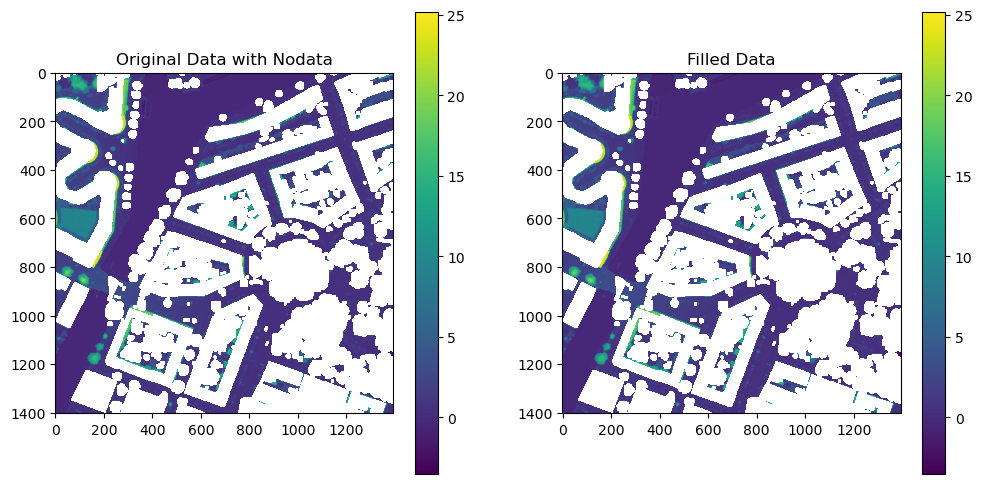

In [15]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Function to interpolate the nodata values
def interpolate_nodata(data, nodata_value):
    # Create a mask for nodata values
    mask = data == nodata_value
    # Get coordinates of valid data points
    coords = np.array(np.nonzero(~mask)).T
    values = data[~mask]
    # Get coordinates of nodata points
    coords_nodata = np.array(np.nonzero(mask)).T
    
    # Interpolate using griddata
    filled_data = data.copy()
    filled_data[mask] = griddata(coords, values, coords_nodata, method='linear')
    return filled_data

# Path to your input raster file
input_raster = '../data/clean_data/canopydsm/dtm_raw.tif'
output_raster = '../data/clean_data/canopydsm/dtm.tif'

# Open the raster file
with rasterio.open(input_raster) as src:
    # Read the data
    data = src.read(1)
    profile = src.profile
    nodata_value = src.nodata if src.nodata is not None else -9999  # Assuming -9999 as a common nodata value if not set

    # Interpolate the nodata values
    filled_data = interpolate_nodata(data, nodata_value)

    # Save the filled raster
    profile.update(dtype=rasterio.float32, nodata=nodata_value)

    with rasterio.open(output_raster, 'w', **profile) as dst:
        dst.write(filled_data, 1)

# Plot the original and filled data for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original data
cax1 = ax1.imshow(np.where(data == nodata_value, np.nan, data), cmap='viridis')
ax1.set_title('Original Data with Nodata')
fig.colorbar(cax1, ax=ax1, orientation='vertical')

# Filled data
cax2 = ax2.imshow(filled_data, cmap='viridis')
ax2.set_title('Filled Data')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

plt.show()


In [104]:
re.shape

(19345,)

In [112]:

def making_geotiff(array, height_cells, width_cells, output, bbox):
    """ This function converts an array into a geotiff.
        Input:
            array:          Array containing the laplace interpolated values (np.array)
            cell_amount:    length and width amount of the cells in the array  (int)
            output:         name of the output file (without .tiff!) (string)
            bbox:           tuple giving bounding box information (min_x, min_y, max_x, max_x, max_y as floats/int)
        Output:
            function returns none but a file is written at ../data/{output}.tiff
    """

    transform = rasterio.transform.from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], height_cells, width_cells)
    location = f'{output}.tiff'
    with rasterio.open(location,'w',
                       driver='GTiff',
                       height=height_cells,
                       width=width_cells,
                       count=1,
                       dtype=array.dtype,
                       crs='EPSG:32631',
                       transform=transform) as dst:
        dst.write(array, 1)


In [111]:
testing = making_geotiff(re, 1403, 1394, "dtm", dt.get_bbox())

ValueError: Source shape (1, 19345) is inconsistent with given indexes 1

In [89]:
re.shape

(19587,)

In [68]:
from scipy.ndimage import map_coordinates
# Define the target grid
target_height = src.height * 2  # For example, doubling the resolution
target_width = src.width * 2
rows, cols = np.mgrid[0:target_height, 0:target_width]

# Map the target grid to the source raster's coordinates
x_coords = cols * (src.width / target_width)
y_coords = rows * (src.height / target_height)
coords = np.array([y_coords, x_coords])

# Interpolate using bilinear method
interpolated_data = map_coordinates(dtm_raw, coords, order=1, mode='nearest')

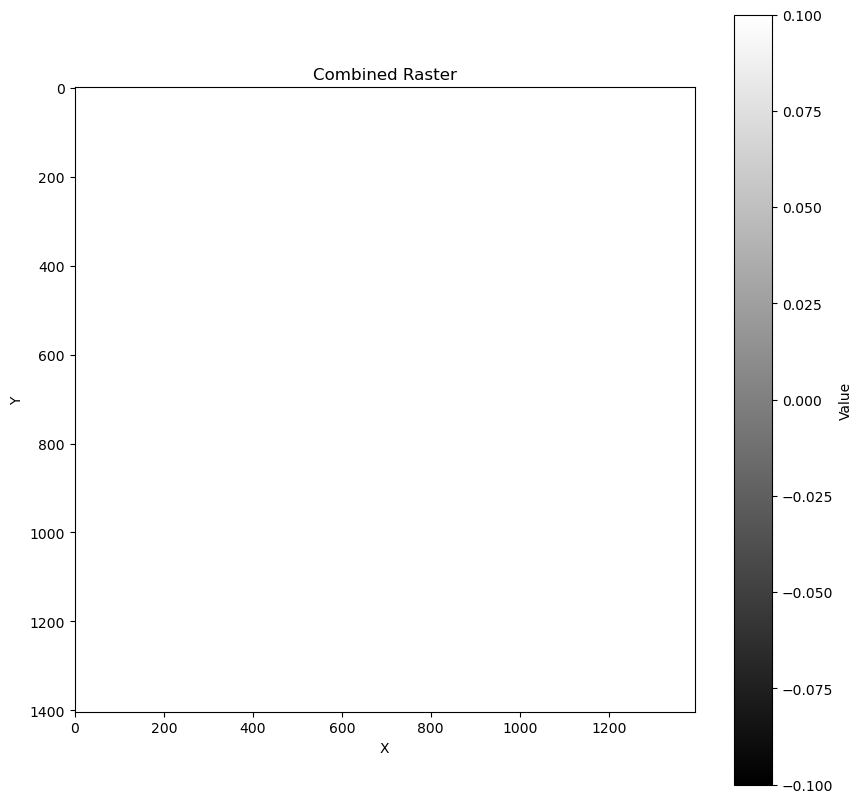

In [72]:
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(interpolated_data, cmap='gray')
plt.title('Combined Raster')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Old

In [ ]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()

# Read canopy poly
trees = gpd.read_file('../../../TU Delft/Projects/lidR/25EZ1_21.gpkg')


# Rasterize tree polygons (same size as dsm so it works with UMEP)
tree_mask = rasterize(
    ((mapping(geom), 1) for geom in trees.geometry),
    out_shape=dsm.shape,
    transform=dsm_meta['transform'],
    fill=0,
    dtype='uint8'
)

# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, np.nan)

# Save Canopy DSM
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('canopy_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(canopy_dsm, 1)

# Remove Trees from DSM (interpolation)
from scipy.ndimage import generic_filter

def interpolate(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

ground_dsm = generic_filter(canopy_dsm, interpolate, size=5, mode='nearest')

# Save Ground DSM
with rasterio.open('ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)


In [3]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()
    dsm_crs = src.crs

In [4]:
# Read DSM
with rasterio.open('../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif') as src:
    dsm = src.read(1)
    dsm_meta = src.meta.copy()
    dsm_crs = src.crs
    # Read tree polygons
    trees = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/lidR/results/25EZ1_21.gpkg')
    trees_crs = trees.crs

    # Check and reproject if necessary
    if trees_crs != dsm_crs:
        trees = trees.to_crs(dsm_crs)


    trees.geometry = trees.buffer(0.5)

        # Mask DSM with tree polygons
    masked_dsm, _ = mask(src, trees.geometry, crop=True, filled=False)

NameError: name 'mask' is not defined

In [9]:
dsm_crs

CRS.from_epsg(32631)

In [4]:

# Read tree polygons
trees = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/lidR/results/25EZ1_21.gpkg')
trees_crs = trees.crs

# Check and reproject if necessary
if trees_crs != dsm_crs:
    trees = trees.to_crs(dsm_crs)


trees.geometry = trees.buffer(0.5)




In [9]:
trees.explore()

TODO: Trees need a buffer and maybe a union (even though that operation isn't necessary?)

In [6]:
# Rasterize tree polygons
tree_mask = rasterize(
    ((mapping(geom), 1) for geom in trees.geometry),
    out_shape=dsm.shape,
    transform=dsm_meta['transform'],
    fill=0,
    dtype='uint8'
)


What I was trying here was to see what input is needed for UMEP function. It seems like it doesn't like NAN values, but prefers 0 instead for nodata. Needs it for both the dsm as well as the canopy dsm. 

In [13]:

# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, 0)

In [11]:
# Create Canopy DSM
canopy_dsm = np.where(tree_mask == 1, dsm, np.nan)

In [14]:
# Save Canopy DSM
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/canopy_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(canopy_dsm, 1)

In [20]:
# Remove Trees from DSM (interpolation)
from scipy.ndimage import generic_filter

In [24]:
# Interpolation function
def interpolate(data):
    mask = np.isnan(data)
    if mask.all():
        return np.nan  # Handle case where the window is all NaNs
    elif not mask.any():
        return np.mean(data)  # Handle case where the window is all valid values
    else:
        valid_data = data[~mask]
        invalid_data = data[mask]
        interp_values = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), valid_data)
        return np.nanmean(interp_values)

# Remove Trees from DSM (interpolation)
ground_dsm = generic_filter(dsm, interpolate, size=5, mode='nearest')

In [28]:
# Interpolation function
def interpolate(data):
    mask = np.isnan(data)
    if mask.all():
        return np.nan  # Handle case where the window is all NaNs
    elif not mask.any():
        return np.mean(data)  # Handle case where the window is all valid values
    else:
        # Only use ground values by excluding outliers (building heights)
        valid_data = data[~mask]
        valid_data = valid_data[valid_data < np.nanpercentile(data, 90)]
        if valid_data.size == 0:
            return np.nan
        return np.mean(valid_data)

# Remove Trees from DSM (interpolation)
ground_dsm = generic_filter(dsm, interpolate, size=15, mode='nearest')

In [29]:
# Save Ground DSM
with rasterio.open('../data/clean_data/canopydsm/ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)

In [30]:
from scipy.ndimage import minimum_filter

In [31]:
# Create a copy of the DSM to fill in tree areas
ground_dsm = np.copy(dsm)

# Define the size of the local window
window_size = 15  # Adjust this size based on your data resolution

# Compute the local minimum using a minimum filter
local_min = minimum_filter(dsm, size=window_size, mode='nearest')


# Replace tree pixels in the DSM with the local minimum
ground_dsm[tree_mask] = local_min[tree_mask]

# Save the resulting DSM without trees
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)

In [ ]:
# Create Canopy DSM
ground_dsm = np.where(tree_mask != 1, dsm, np.nan)


In [9]:
# Create Canopy DSM
ground_dsm = np.where(tree_mask != 1, dsm, 0)


In [40]:
# Define the size of the local window
window_size = 50  # Adjust this size based on your data resolution

# Function to replace NaNs with local minimum
def fill_with_local_minimum(data):
    center_index = len(data) // 2
    if np.isnan(data[center_index]):
        return np.nanmin(data)
    else:
        return data[center_index]

# Apply the function to the ground_dsm to fill in NaNs with local minimum
filled_dsm = generic_filter(ground_dsm, fill_with_local_minimum, size=window_size, mode='nearest')

# Replace the original NaNs in ground_dsm with the values from filled_dsm
ground_dsm[np.isnan(ground_dsm)] = filled_dsm[np.isnan(ground_dsm)]

/var/folders/qg/ghhvk02j7t3f3b9th5d2412rxxy23f/T/ipykernel_37927/845014348.py:8: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(data)


In [10]:
# Save the resulting DSM without trees
dsm_meta.update(dtype='float32', nodata=np.nan)
with rasterio.open('../data/clean_data/canopydsm/ground_dsm.tif', 'w', **dsm_meta) as dst:
    dst.write(ground_dsm, 1)

In [43]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

In [60]:
# Get coordinates of non-tree pixels
rows, cols = np.where(~tree_mask)
points = np.column_stack((rows, cols))

# Interpolate using Delaunay triangulation
tri = Delaunay(points)
interpolator = LinearNDInterpolator(tri, ground_dsm[~tree_mask])

# Create meshgrid for whole DSM
all_rows, all_cols = np.indices(dsm.shape)
all_points = np.column_stack((all_rows.ravel(), all_cols.ravel()))

# Mask for nodata areas
nodata_mask = np.isnan(ground_dsm)

# Interpolate nodata values using the interpolator
ground_dsm[nodata_mask] = interpolator(all_points[nodata_mask])

# Ensure no negative values (optional step based on DSM characteristics)
ground_dsm[ground_dsm < 0] = 0

KeyboardInterrupt: 

In [51]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt


In [61]:
# Mask DSM with tree polygons
masked_dsm, _ = mask(src, trees.geometry, crop=True, filled=False)


RasterioIOError: Dataset is closed: ../data/clean_data/solar/12011952/12011952_p_6_2022_06_02_dsm.tif

In [57]:
dsm

array([[13.238157  , 13.241913  , 13.240485  , ..., 16.200573  ,
        16.207281  , 16.074492  ],
       [13.245048  , 13.248777  , 13.248334  , ..., 16.122526  ,
        15.708638  , 15.181873  ],
       [13.253944  , 13.256381  , 13.257053  , ..., 15.487819  ,
        13.826398  , 13.284081  ],
       ...,
       [ 0.49462113,  0.36046892, -0.06656245, ...,  0.5232695 ,
         0.51917964,  0.5190234 ],
       [ 0.4995078 ,  0.33632842, -0.15410125, ...,  0.5123671 ,
         0.51407814,  0.5257422 ],
       [ 0.49675155,  0.3318245 , -0.15537861, ...,  0.5103445 ,
         0.519032  ,  0.52425385]], dtype=float32)

In [ ]:
# Or visualize the filled DSM
plt.imshow(dsm_filled, cmap='terrain')
plt.colorbar()
plt.show()

In [ ]:
from scipy.interpolate import griddata

# Convert masked_dsm to a numpy array
dsm_array = masked_dsm[0]  # assuming masked_dsm is a masked array

# Create a grid of coordinates where NaNs need to be filled
y_nan, x_nan = np.where(np.isnan(dsm_array))
points = np.array([x_nan, y_nan]).T
values = dsm_array[~np.isnan(dsm_array)]

# Interpolate using nearest neighbor (you can choose other methods based on your preference)
dsm_filled = griddata(points, values, (x, y), method='nearest')